# Stochastic Gradient Hamiltonian Monte Carlo

#### Alex Chin, Taras Holovko, Jason Huang, Tyler Yan

#### [0. Background](#Background)
#### [I. Technical Content](#Technical-Content)
#### [II. Implementation](#Implementation)
#### [III. Bayesian Linear Regression](#Bayesian-Linear-Regression)
#### [IV. Bayesian Logistic Regression](#Bayesian-Logistic-Regression)
#### [V. Artificial Stochastic Gradients](#Artificial-Stochastic-Gradients)
#### [VI. Computational Complexity](#Computational-Complexity)
#### [VII. Freeze Proposal](#Freeze-Proposal)
#### [VIII. Discussion](#Discussion)
#### [IX. Conclusion](#Conclusion)

## Background

### Problem and Context

Hamiltonian Monte Carlo sampling methods, originally proposed by Duane et al. (1987), possess powerful, desirable properties of MCMC algorithms. Namely, they are able to rapidly explore state spaces and define distant proposals with high acceptance probabilities under the Metropolis-Hastings framework by defining a Hamiltonian dynamical system of potential energy, kinetic energy, and an added set of momentum variables. 

Despite its ability to rapidly explore state spaces, HMC is majorly limited by slow computation of the gradient of the potential energy function, which is needed to simulate Hamiltonian dynamics. Gradient computation scales with dataset size and more than ever, datasets now contain orders of magnitude more observations than before. Moreover, statistical inference must sometimes be done online, meaning that training data grows with time, and inference should be updated in an efficient manner as new data arrives. HMC requires that it looks at the entire dataset every time a gradient is computed, which can be computationally infeasible with incredibly large datasets. Furthermore, even if this computation is tenable within a somewhat reasonable timeframe, a small addition of data requires a complete recomputation of gradients under the canonical HMC paradigm.

### Existing Work and Contribution

Though a slightly different problem from sampling, optimization methods have encountered similar issues in real world "big data" applications. The solution in this field has been via stochastic approximation of optimization goals, usually by a process called mini-batching. Previous work, mostly in the context of optimization, has been done by Robbins & Monro (1951) on stochastic approximation methods, Hoffman et al. (2013) on stochastic variational inference, Welling & Teh (2011) on stochastic gradient Langevin dynamics, and Nimrovski et al. (2009) on stochastic approximation approaches to stochastic programming, all of which have been cited by Chen, Fox, and Guestrin as primary sources of inspiration for this algorithm. 

As an example of previous work on this topic (also covered previously in AM207), Stochastic Gradient Descent tackles similar issues in optimization; instead of potential energy, loss/objective function gradients must be calculated using entire datasets. Stochastic Gradient Descent is the solution to many of these problems in big data by providing a fast way to optimize functions and subsequently reoptimizing them if new data comes in. Stochastic Gradient Descent works by only computing the gradient with respect to small "mini-batches" of the data before descending along the path of the gradient. Subsequently, SGD then looks at mini-batches in sequence, and after each batch, it moves the same distance that canonical gradient descent might move after looking at the entire dataset. The ensuing result of SGD is the rapid calculation of a "noisy" gradient, where noise around the true gradient is induced by only looking at random subset of the data.

This paper by Chen, Fox, and Guestrin, marries the two ideas of stochastic mini-batch gradient computation with Hamiltonian dynamics to produce Stochastic Gradient Hamiltonian Monte Carlo. SGHMC is designed to create an efficient, and potentially online, stochastic approach to Bayesian posterior sampling. At a high level, this paper addresses the inefficiencies of canonical HMC on large datasets by utilizing an analogous approach to Stochastic Gradient Descent. By mini-batching the data, and computing gradients on those subsets of the data, Stochastic Gradient HMC attempts to vastly improve the speed of traditional HMC by no longer looking at the entire dataset for potential energy function traversal. Simply mini-batching data is rather intuitive, and based on the success of Stochastic Gradient Descent, one might expect it to work quite well, but this "naive" SGHMC approach actually lacks theoretically convergent properties. As such, this paper further introduces the idea of "friction" added to the momentum update, and demonstrates how that revision retains stationarity at the target distribution. Completing the algorithm with this revision, Stochastic Gradient HMC lays the groundwork for both fast and explorative Bayesian sampling under Hamiltonian Dynamics. This innovation can yield undiscovered, real-world applications of HMC to Bayesian Inference in large, dynamic datasets.

### Technical Content

Before presenting its technical contributions, the paper summarizes HMC sampling. Since we have already covered this in class, we choose not to summarize this part of the paper. The paper introduces \textbf{two new technical approaches}. The first is \textbf{Naive Stochastic Gradient Hamiltonian Monte Carlo} (NSGHMC), and the second is \textbf{Stochastic Gradient Hamiltonian Monte Carlo} (SGHMC). The high level idea of NSGHMC is to calculate the gradient based on a subset of the points in the update step. Since it can be expensive to do computations with an entire dataset, it is SGHMC uses small batches to improve efficiency. However, this efficiency gain comes at the cost of adding increased noise, which is why the paper suggests SGHMC. The high-level idea of SGHMC is to use friction to reduce the noise. We can think of HMC as a ball moving around a potential energy landscape of hills and valleys. Stochasticity introduces noise, which we can conceptualize as wind pushing the ball randomly. We can reduce the effect of this wind by making the ground stickier, which is the same thing as adding friction!

After providing the high-level summary of the two new HMC samplers, we now provide some more technical details.

Chen et al. appeal to the central limit theorem when in characterizing the errors that arise from stochasticity. They say that empirically, a sample size of 100 is sufficient to see normally distributed error from batching. The most important result here is that the entropy ($-\int_{\theta,r}f(p_t(\theta,r))d\theta dr$ for $f=x\log(x)$) of the NSGHMC increases, so it does not have the same invariance properties as normal HMC. A possible solution would be to use a Metropolis-Hastings correction step, but since this requires reexamining all the data, it defeats the initial purpose of the NSGHMC. This is the core motivation for SGHMC.

The SGHMC uses an additional term in the leapfrog update step to represent the friction. In particular, the update is goverened by the following dynamics
$$d\theta = M^{-1}r dt, dr = -\nabla U(\theta)dt\underbrace{-BM^{-1}rdt}_{\mathrm{Friction}} + \underbrace{\mathcal{N}(0,2Bdt)}_{\mathrm{Noise}}$$
The first equation is identical to the normal procedure for updating position. The second equation introduces two terms. First the $\mathcal{N}(0,2Bdt)$ represents the added Gaussian noise (recall the stochastic noise for batch sizes larger than a hundred is approximated as a Gaussian by the central limit theorem). Second, $-BM^{-1}rdt$ represents the added friction term. We see that this term reduces large values of $r$ since it reduces $dr$ proportionally to $r$. The paper proves these dynamics have a stationary distribution of the hamiltonian, but the practical issue is that $B$ is unknown because we don't know the stochastic noise. As such, Chen et al. provide a more practical version of the dynamics and prove important results for that. The dynamics for this system are below
$$d\theta = M^{-1}rdt, dr = -\nabla U(\theta)dt-CM^{-1}rdt+ \mathcal{N}(0,2(C - \hat B)dt)+ \underbrace{\mathcal{N}(0,2Bdt)}_{\mathrm{Noise}}$$
Again, the rule for the position update is the same. However, the rule for the momentum update is slightly different. In this case, we assume we have two user specified quantities: an estimate of noise $\hat B$ and a friction parameter $C$. These dynamics have two important properties. First, if $\hat B = B$, so our estimate is correct, these simplify to the above dynamics and thus have the correct stationary distribution. This motivates their validity, but does not make them any more practical since their impetus was that we did not know the true $B$ value. The more practical property is that as the step size $\epsilon \to 0$, stochastic noise $B = \frac{1}{2}\epsilon V\to 0$ also. Using this approximation, we can set $\hat B = 0$, and then the dynamics are governed by $C$ and by the first property have the correct stationary distribution.

### Experiments

#### Toy Models

Toy models are extremely simple examples where the expected behaviors are well understood. As such, they make for excellent proof of concepts and help illustrate the theory in the paper. In the case of this paper, Chen et al. use toy models to demonstrate that their theory has practical applications, mostly by highlighting the issues with NSGHMC and how SGHMC (with friction) performs better in these examples.

- In the first toy model, Chen et al. test the sampling ability of SGHMC and NSGHMC with and without Metropolis-Hastings correction on sampling from the distribution $U(\theta)=-2\theta^2+\theta^4$. This is a bimodal distribution, so it is not trivial to sample from. This is a relatively simple example that validates their construction, and it also demonstrates an example in which NSGHMC without Metropolis-Hastings fails. Recall in the technical content section that Chen et al. finds that Metropolis-Hastings is necessary to correct for the increasing entropy in NSGHMC,  and this example effectively demonstrates  this.
- In the second toy examaple, Chen et al. sample directly from the Hamiltonians for different samplers and find that NSGHMC again has issues because of its lack of friction. In particular, it does not give the proper Hamiltonian dynamics. Given the simple nature of the example, this is again effective in establishing their point.
- In the third example, Chen et al. compare SGHMC and SGLD in sampling from correlated distributions. This relates to an earlier section of the paper where Chen et al. relate SGHMC to SGLD through Langevin dynamics. The end result is that SGHMC samples much more efficiently than SGLD. While it is fair to make this comparison so as to indicate why SGHMC is better than SGLD (as they will be compared heavily in the empirical applications), since the main focus of the paper is on comparing SGHMC and NSGHMC, it would be helpful for the authors to also run NSGHMC on this example (to show it either fails or is also less efficient than SGHMC).
\end{enumerate}
 

#### Empirical Applications

The purpose of the empirical applications is to evaluate the applicability of the model to real life scenarios (external validity). Since the scenarios are more complex, they don't lend themselves as easily to understanding the particulars of 

- Bayesian Neural Networks: For this experiment, the authors train a two-level BNN on the MNIST handwriting dataset. After tuning for hyperparameters, they compare SGD, SGLD,  SGD with momentum, and SGHMC for sampling the posterior of the weights. In the end, the paper concludes that sampling methods are preferable to optimization methods, with SGHMC having consistently lower test error throughout. While this is convincing evidence for an SGHMC use case, the authors note that the backpropogation is the dominating cost in this computation. As such, this motivates the question as to whether in applications where sampler speed is the key constraint (as opposed to sampler iterations as for a BNN), SGHMC will  also be preferable. This motivates our project's timing analysis.
- Probabilistic Matrix Factorization: Probabilistic matrix factorization is integral for recommendation and filtration tasks, so demonstrating that SGHMC is a valid technique for probabilistic matrix factorization is an excellent way to bolster its practical value. Moreover, it represents an excellent application where the dataset is immense so a valid stochastic technique is justified. Comparing against the same suite of samplers, Chen et al. find that SGHMC has the lowest RMSE after 5-fold cross-validation. These results again bode well for SGHMC as a technique. 

An overall critique of the empirical applications is that Chen et al. should run the normal HMC in these cases to see how much of a speedup SGHMC provides.

### Evaluation

First, we should evaluate the motivation. The original motivation for using stochasticity is that if there are too many data points, evaluation can become extremely slow. The two examples in the paper of BNNs and Probabilistic Matrix Factorization (recall this is used in things like movie recommendations that can have millions of data points) are excellent use cases. Another we have discussed in class is hierarchical models, specifically for kidney cancer. Medical models often include millions of individuals, and this can increase computational complexity. Thus, the model is well-motivated.

Turning to the theory, the theoretical results (Section 3.2 in the paper, and the first set of dynamics described in our Technical Content section) are mathematically valid. The main question in evaluating the work is the practical viability. The proof of validity for SGHMC in practice (Section 3.3 in the paper, and the second set of dynamics in our Technical Content section) is less rigorous. It relies on the assumption that B is asymptotically small such that C dominates. This may not hold in practice. The other practical issue is (as discussed in the Future Work section) is that while theoretically it is valid to use arbitrarily high values of C, these can pose practical issues. High values of friction can make the sampler relatively imobile, which can be an issue if either initial position is very far from the actual distribution (we address this in our thawing experiment) or overly high values of friction prevent sampling the full distribution (we see this in our Gridsearch section).

Despite these limitations, the empirical tests from the paper of BNN and Probabilistic Matrix Factorization demonstrate that with sufficient tuning, SGHMC can be applied to solve a number of problems effectively. Thus, these indicate that overall the work is technically sound and applicable to the real world.

### Future Work

There are a number of improvements that can be made to SGHMC. Overestimating friction should not have asymptotic effects according to the paper (i.e. as iterations go to infinity, the sampled distribution is correct), it does have practical effects. We think these are the biggest places that this method can be improved. For example, as we will discuss in our section on gridsearch, using too high levels of friction can cause the sampler to become stuck in high-density areas, or simply not sample low-density areas (even over a high number of iterations--10,000). Modifications to ameliorate this issue would be a great place for future research.

We choose to address another limitation posed by friction in our project. As we will describe later in our experiments section (see the section on thawing), a downside of high levels of friction is that if the initial position of the sampler is far from the high-mass area, it takes an extremely long time to burn-in. Since a major point of SGHMC is to reduce computational time, this poses a large issue for the method. We suggest a “thawing” method where the sampler starts at low friction and gradually increases to high friction and demonstrate its success in a toy example.

## Technical Content

This project seeks to thoroughly investigate the techniques proposed by Chen, Fox, and Guestrin in their 2014 paper titled "Stochastic Gradient Hamiltonian Monte Carlo", which aims to apply the stochastic gradient trick commonly used in gradient descent problems to the HMC sampler in the hopes of improving computational complexity of the algorithm. 

Before presenting its technical contributions, the paper summarizes HMC sampling. Since we have already covered this in class, we choose not to summarize this part of the paper. The paper introduces **two new technical approaches**. The first is **Naive Stochastic Gradient Hamiltonian Monte Carlo** (NSGHMC), and the second is **Stochastic Gradient Hamiltonian Monte Carlo** (SGHMC). The high level idea of NSGHMC is to calculate the gradient based on a subset of the points in the update step. Since it can be expensive to do computations with an entire dataset, it is SGHMC uses small batches to improve efficiency. However, this efficiency gain comes at the cost of adding increased noise, which is why the paper suggests SGHMC. The high-level idea of SGHMC is to use friction to reduce the noise. We can think of HMC as a ball moving around a potential energy landscape of hills and valleys. Stochasticity introduces noise, which we can conceptualize as wind pushing the ball randomly. We can reduce the effect of this wind by making the ground stickier, which is the same thing as adding friction!

After providing the high-level summary of the two new HMC samplers, we now provide some more technical details.

Chen et al. appeal to the central limit theorem when in characterizing the errors that arise from stochasticity. They say that empirically, a sample size of 100 is sufficient to see normally distributed error from batching. The most important result here is that the entropy ($-\int_{\theta,r}f(p_t(\theta,r))d\theta dr$ for $f=x\log(x)$) of the NSGHMC increases, so it does not have the same invariance properties as normal HMC. A possible solution would be to use a Metropolis-Hastings correction step, but since this requires reexamining all the data, it defeats the initial purpose of the NSGHMC. This is the core motivation for SGHMC.

The SGHMC uses an additional term in the leapfrog update step to represent the friction. In particular, the update is goverened by the following dynamics
$$d\theta = M^{-1}r dt, dr = -\nabla U(\theta)dt\underbrace{-BM^{-1}rdt}_{\mathrm{Friction}} + \underbrace{\mathcal{N}(0,2Bdt)}_{\mathrm{Noise}}$$
The first equation is identical to the normal procedure for updating position. The second equation introduces two terms. First the $\mathcal{N}(0,2Bdt)$ represents the added Gaussian noise (recall the stochastic noise for batch sizes larger than a hundred is approximated as a Gaussian by the central limit theorem). Second, $-BM^{-1}rdt$ represents the added friction term. We see that this term reduces large values of $r$ since it reduces $dr$ proportionally to $r$. The paper proves these dynamics have a stationary distribution of the hamiltonian, but the practical issue is that $B$ is unknown because we don't know the stochastic noise. As such, Chen et al. provide a more practical version of the dynamics and prove important results for that. The dynamics for this system are below
$$d\theta = M^{-1}rdt, dr = -\nabla U(\theta)dt-CM^{-1}rdt+ \mathcal{N}(0,2(C - \hat B)dt)+ \underbrace{\mathcal{N}(0,2Bdt)}_{\mathrm{Noise}}$$
Again, the rule for the position update is the same. However, the rule for the momentum update is slightly different. In this case, we assume we have two user specified quantities: an estimate of noise $\hat B$ and a friction parameter $C$. These dynamics have two important properties. First, if $\hat B = B$, so our estimate is correct, these simplify to the above dynamics and thus have the correct stationary distribution. This motivates their validity, but does not make them any more practical since their impetus was that we did not know the true $B$ value. The more practical property is that as the step size $\epsilon \to 0$, stochastic noise $B = \frac{1}{2}\epsilon V\to 0$ also. Using this approximation, we can set $\hat B = 0$, and then the dynamics are governed by $C$ and by the first property have the correct stationary distribution.


## Implementation

The implementations are included in a separate code file, `hmc.py`. There are three primary functions of relevance for the first few pedagogical examples.

In [1]:
from hmc import hmc    # standard HMC sampler
from hmc import nsghmc # naive stochastic gradient HMC
from hmc import sghmc  # stochastic gradient HMC with friction

Before moving onto more involved implementations of pedagogical examples, the following dependencies will be imported.

In [2]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import autograd.scipy.stats as st
import seaborn as sns
import pandas as pd
import time
%matplotlib inline

## Bayesian Linear Regression

### Setup

We begin with a standard pedagogical example commonly used for sampling, which is Bayesian linear regression.

The generative process for the data is below. Fix some $m,b, \sigma$. We sample $x\sim Unif(0,1)$. For every $x$, we sample data points $y\sim \mathcal{N}(mx+b, \sigma^2)$.

In [3]:
# configuration for true data generating process (DGP)
sigma = 1                  # sigma (observation noise)
n_data_points = 10000      # number of data points in data set
m, b = 1,1                 # true parameters of DGP

In [4]:
# generate the data
X = np.random.uniform(size=n_data_points)
Y = np.random.normal(X * m + b, sigma)

The samplers should be able to return samples that are representative of the target posterior distribution. A Gaussian prior will be placed on the parameters $m, b\overset{i.i.d.}{\sim} \mathcal{N}(0, 1)$ and the likelihood for the data points are Gaussian as well as seen above, so by conjugacy the posterior will also be Gaussian. Its negative log-likelihood is implemented here.

In [67]:
# Gaussian prior
coef_mean = np.ones(2)
coef_cov = np.eye(2)

# Gaussian posterior negative log likelihood for Bayesian linear regression
def linear_nll(w, x_train, y_train):
    m, b = w
    # data likelihood
    likelihood = np.sum(st.norm.logpdf(y_train, x_train * m + b, scale=sigma))
    # Gaussian prior
    prior = st.multivariate_normal.logpdf(w, coef_mean, coef_cov)
    # return posterior
    return -(prior + likelihood)

Recall for HMC the target function is evaluated on the whole data set, so that will be implemented here as well.

In [6]:
# evaluating the negative log likelihood on the full data set
def linear_nll_full(w):
    return linear_nll(w, X, Y)

The target posterior can be visualized graphically using a Kernel Density Estimator plot. Note that this is a 2-dimensional sample space.

In [7]:
# Note: graphing code from (https://seaborn.pydata.org/tutorial/distributions.html)
new_X = np.vstack((X, np.ones(X.shape[0])))
mean = np.linalg.inv(np.dot(new_X, new_X.T) + sigma**2 * np.linalg.inv(coef_cov)) @ new_X @ Y
cov = np.linalg.inv(np.dot(new_X, new_X.T) * sigma**(-2) + np.linalg.inv(coef_cov))
data = np.random.multivariate_normal(mean, cov, 500)
df = pd.DataFrame(data, columns=["m", "b"])

In [8]:
cmap = sns.cubehelix_palette(as_cmap=True, dark=1, light=0, reverse=True)

In [9]:
# general graphing utility function
def visualize2d(actual, samples=None, title=''):
    # true underlying distribution
    sns.kdeplot(actual.iloc[:,0], actual.iloc[:,1], cmap=cmap, n_levels=60, shade=True)
    # scatter plot of samples
    if samples is not None:
        plt.scatter(samples[:,0], samples[:,1], alpha=0.3, s=5, color='red')
    if title != '':
        plt.title(title)

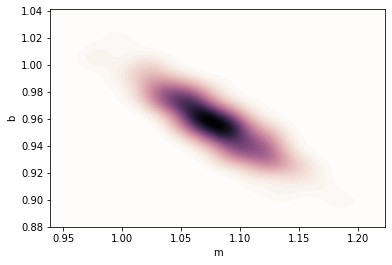

In [10]:
visualize2d(df)

### HMC

Now run the HMC sampler. Below is the parametrization that will be used. For consistency, this configuration will be used across all the samplers for this specific pedagogical example, though naturally the other samplers may require additional parameters beyond these. To briefly summarize, 1000 samples will be taken from an initial starting point of $m=0, b=0$. The mass will be an identity matrix, while the step size is $\epsilon = 10^{-3}$ and path length is 0.05.

In [11]:
# sampler parametrization
nsamples = 1000
init_pos = np.array([0., 0.])
mass = np.eye(2)
step_size = 1e-3          
path_len = 50 * step_size

burn_in = 0.1
thinning = 2

The standard HMC sampler will be run now with the resulting samples visualized against the true distribution.

In [118]:
# run HMC sampler
hmc_results = hmc(M=mass, n_samples=nsamples, negative_log_prob=linear_nll_full, initial_position=init_pos,
                  path_len=path_len, step_size=step_size)

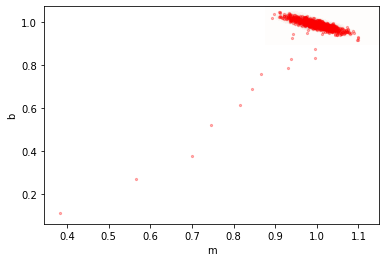

In [119]:
visualize2d(df, hmc_results[0])

To aid with visualization and to focus on the samples that specifically represent the target distribution, samples can be discarded for the _burn-in_ portion and through _thinning_.

In [78]:
def clean(samples, burn_in=0, thinning=1):
    return samples[int(burn_in * len(samples))::thinning]

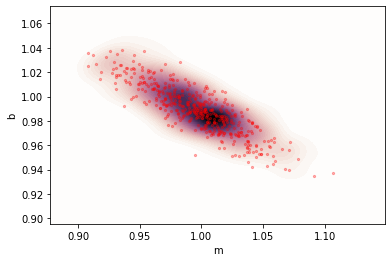

In [113]:
visualize2d(df, clean(hmc_results[0], burn_in, thinning))

The result looks good, as the sampler quickly travels to the bulk of the target distribution and provides a representative sample. Below are traceplots of all the samples, which again show that the target distribution is quickly reached and fully represented.

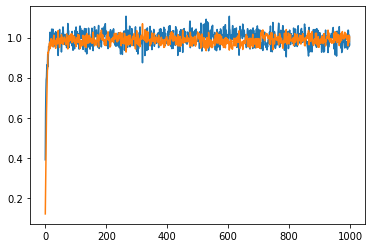

In [117]:
# traceplots
plt.plot(hmc_results[0])
plt.show()

### Naive SGHMC

Now the same algorithm can be run for the Bayesian linear regression case, except with naive batching of the data sets to compute quicker noisy gradients. This sampler is titled the Naive SGHMC by the authors of the paper. Note that the parametrization remains the exact same as was used for the HMC sampler above. There are only 3 additional parameters being passed:
- the data set $X, Y$ needs to be passed so the sampler can handle batching
- a batch size needs to be declared, specifying how many data points to include in each subset when computing a stochastic gradient

Furthermore, the original more flexible negative log probability needs to be used, in order for the sampler to take the stochastic gradient for a subset of the data, rather than precomputing it on the full data set. Apart from these minor differences, all very intuitively related to the concept of batching for stochastic gradients, the setup is the exact same as in the HMC sampler.

In [34]:
batch_size = 500
# run naive SGHMC sampler
nsghmc_results = nsghmc(X, Y, M=mass, n_samples=nsamples, negative_log_prob=linear_nll,
                        initial_position=init_pos, batch_size=batch_size, path_len=path_len, step_size=step_size)

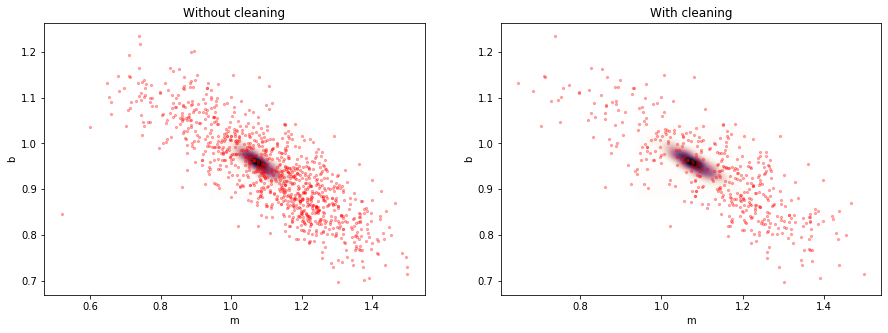

In [35]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
visualize2d(df, nsghmc_results[0], title='Without cleaning')
plt.subplot(1, 2, 2)
visualize2d(df, clean(nsghmc_results[0], burn_in, thinning), title='With cleaning')

Clearly, naive SGHMC fails to properly sample from the posterior, even when focusing on the samples after thinning and removing the burn-in. It is worth noting that the samples are still somewhat representative of the shape of the distribution, but with substantially higher variance, likely owing to the additional stochasticity introduced by batching. The same can be seen in the traceplots as well.

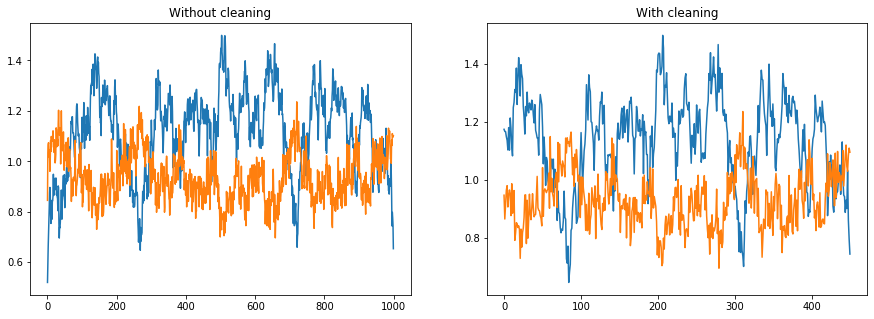

In [36]:
# traceplots
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(nsghmc_results[0])
plt.title('Without cleaning')
plt.subplot(1, 2, 2)
plt.plot(clean(nsghmc_results[0], burn_in, thinning))
plt.title('With cleaning')
plt.show()

### SGHMC

Finally, the SGHMC sampler proposed by the paper will be used. A friction term is introduced by SGHMC, in addition to the batching that naive SGHMC had. This actually quite well-motivated based on the naive SGHMC result above, since the variance appears to be too high but the samples are otherwise somewhat representative and do not appear to be biased, so controlling the magnitude of exploration by a stochastic gradient with a friction term is quite reasonable.

The only extra parameters, in addition to the ones introduced by naive SGHMC, pertain to friction, as proposed by the paper. One is $V$, which is the true variance of the stochastic gradients. However, note that this is often note known or immensely difficult to find out. The authors suggest empirical Fisher information as one way to estimate this value, but also note that a value of 0 is sufficient, and that is used here. $C$ is the new term and represents an upper bound of $V$ for the friction term. Ultimately, friction is introduced with magnitude $C-\hat{B}$, where $B = \frac{1}{2}V$, so these parameters should be jointly determined anyway. All other parameters are same as the previous paramterizations.

In [37]:
C = 300 * np.eye(2)
V = np.zeros((2, 2))
# run SGHMC sampler
sghmc_results = sghmc(X, Y, M=mass, C=C, V=V, n_samples=nsamples, negative_log_prob=linear_nll,
                      initial_position=init_pos, batch_size=batch_size, path_len=path_len, step_size=step_size)

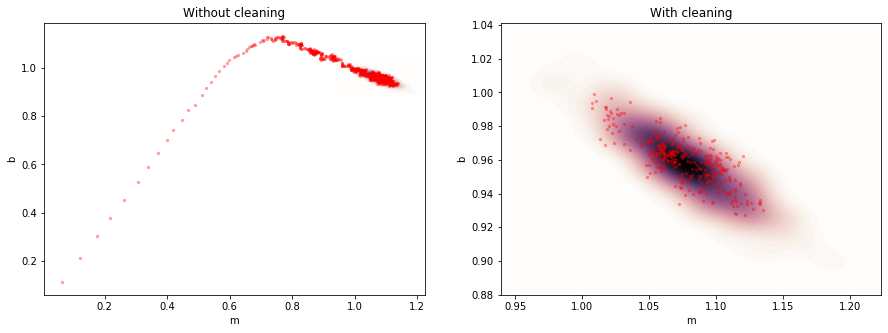

In [39]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
visualize2d(df, sghmc_results[0], title='Without cleaning')
plt.subplot(1, 2, 2)
visualize2d(df, clean(sghmc_results[0], 0.3, thinning), title='With cleaning')

In [ ]:
# traceplots
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(sghmc_results[0])
plt.title('Without cleaning')
plt.subplot(1, 2, 2)
plt.plot(clean(sghmc_results[0], burn_in, thinning))
plt.title('With cleaning')
plt.show()

### Grid Search
Taking a step back, while the above results were well-tuned for presentation and pedagogical purposes, they required a careful parameter search.

Before doing other experiments, we wanted to experiment with how friction and batch size, the two key user inputs, would alter the performance of SGHMC. We conducted a gridsearch on parameters to experiment with different combinations. We chose to conduct this analysis on the pedagogical example of linear regression so as to make sure we could fully understand the results and compare it against a known, closed-form, analytic posterior. We chose to use the values of $0, 1, 10, 25, 50, 100, 150, 200, 300, 500$ for friction and $1, 50, 100, 300, 500, 1000$ for batch size. We saw diminishing marginal effects for friction higher than $500$, so that is why larger values were not explored. Similarly, we used $10000$ data points, so larger batch sizes seemed equivalent to the entire data set. Since this gridsearch took over a day, the code is not presented to be rerun in this notebook. Instead, important posteriors are given as we summarize the results.

Before analyzing anything else, we see that small batch sizes are disasterous. For a batch size of $1$, no level of friction was able to remedy the noise. Since we initialized the gridsearch at the true values of $m,b$, high friction levels kept the sampler relatively bounded within the distribution, but the samples were still not consistent with the posterior. This is consistent with the results of the paper, as the normal approximation of noise does not apply if the batch size is too small. Below we present the samples obtained with a batch size of $1$ at both the lowest and highest levels of friction (to indicate that there was not a large amount of difference even when changing friction).
![title](img/friction_0_batch_1.png)
![title](img/friction_500_batch_1.png)
We now turn to analyzing low friction. For friction levels of $\leq 50$, we saw similar performance. In particular, the sampler had the correct shape, but overall the spread of the sampled distribution was much larger than the true posterior. With higher values of friction, there were marginal increases in the tightness of the distribution, but this did not sufficiently remedy the problem (with one exception that we discuss below). Below we give two examples, and almost all the distributions for $\leq 50$ friction looked like this (with relatively larger and smaller spreads). Both samplers had batch size 300, but the first has friction 0 and the second had friction 50. Note there is a marginal decrease in variance, but neither perform well
![title](img/friction_0_batch_300.png)
![title](img/friction_50_batch_300.png)
The exception to this was for batch sizes of 1000. Here, since the sampler was receiving so many points, the stochastic noise was low, so even low levels of friction were sufficient for the desired behavior. Below is an image of friction 25, batch size 1000.
![title](img/friction_25_batch_1000.png)
At friction levels of $150, 200, 300$, and $500$, the sampler performed a lot better ($100$ performed similarly well for batch sizes $\geq 300$, and otherwise performed more similarly to $\leq 50$--since these results are similar to ones already discussed, they are not discussed explicitly). Consistent with the $100$ batch size heuristic of the paper, the sampled distributions matched the true posteriors for all of these friction levels and batch sizes $\geq 100$. We give images of two of these fits below
![title](img/friction_150_batch_500.png)
![title](img/friction_300_batch_300.png)
The last result of note was that when the sampler was run with too high batch sizes and friction, it would often not sample the lower-density areas of the distribution. This makes sense because the friction terms is added to account for the noisiness of stochastic sampling. However, at batch size of $1000$, there is not a substantial amount of noise being added, so an opressive friction term prevents adequate sampling. Below we can see this effect clearly for the maximum friction $500$ and maximum batch size $1000$ in this gridsearch
![title](img/friction_500_batch_1000.png)
However, this problem appeared to a lesser extent even for a friction of $200$ and a batch size of $1000$. 
![title](img/friction_200_batch_1000.png)
These results imply that empirically, there is a cost to setting friction too high. In other words, the friction level must be appropriate for the batch size (ie higher batch sizes should use lower friction). Although the asymptotic behavior may be guaranteed, high levels of friction can stop the sampler from practically sampling all parts of the distribution

### Bias and Variance of SGHMC in Linear Regression

To examine the behavior of our SGHMC posterior samples, we compare them with the analytical form of the true Linear Regression Posterior. To do so, we simplify the distributions to first and second moments by comparing the sample means with the true posterior mean and comparing the sample covariances with the true posterior covariance via Frobenius Matrix norm. We randomly restart SGHMC 50 times under 5 different parameter sets, to examine the effect of changing friction and batch size on the posterior summary statistics.

Below are scatter plots of the sample means under each parameter set, as well as histograms of sample covariance Frobenius Norm with true covariance.

![](img/bv1.png)
![](img/bv2.png)

Based on the plots of 50 random restarts of SGHMC under different hyperparameters, the bias and variance of the sampled posterior is fairly dependent on hyperparameters. Friction appears to increase the closeness of the empirical covariance matrix to the true covariance matrix. It appears to have a small effect on the bias of the sample means, as a high friction of 300 produces a slightly biased mean of sample means, relative to the true posterior mean. Batch size appears to have no effect on the quality of the empirical covariance matrix. Batch size appears to decrease the variance of the sample means however, which is expected.

## Bayesian Logistic Regression

### Setup and HMC Reference Posterior

Bayesian logistic regression is another common sampling problem that will be useful here for pedagogical purposes too. It is the foundational example for problems involving binary data and, in the multivariate case, classification algorithms, compared to the previous linear regression being analogous to regression problems. The generative process for is $y\sim Bin(sigmoid(mx+b))$.

In [60]:
# configuration for true data generating process (DGP)
sigma = 1                  # sigma (observation noise)
n_data_points = 10000      # number of data points in data set
m, b = 1,1                 # true parameters of DGP

In [101]:
from autograd.scipy.special import expit
# Generate data
X = np.random.uniform(size=n_data_points)
Y = np.random.binomial(1, expit(X * m + b))

The posterior is implemented and computed below, both for a training batch as well as the full data set.

In [102]:
# Gaussian prior
coef_mean = np.ones(2)
coef_cov = np.eye(2)

# Gaussian posterior negative log likelihood for Bayesian linear regression
def logistic_nll(w, x_train, y_train):
    m, b = w
    lin = m * x_train + b
    # data likelihood
    likelihood = np.sum(y_train * np.log(expit(lin)) + (1 - y_train) * np.log(1 - expit(lin)))
    # Gaussian prior
    prior = st.multivariate_normal.logpdf(w, coef_mean, coef_cov)
    # return posterior
    return -(prior + likelihood)

In [103]:
# evaluating the negative log likelihood on the full data set
def logistic_nll_full(w):
    return logistic_nll(w, X, Y)

Unlike in the Bayesian linear regression case, the posterior of a logistic regression is not known in closed form. What is known is that it is asymmetric and somewhat skewed. However, there is a sufficiently large data set here that it will likely look quite close to a neat distribution. Either way, instead of having a closed form target distribution to validate samples against, since HMC is known to be a robust and correct sampler, it will be used to create the reference posterior distribution.

In [129]:
# sampler parametrization
nsamples = 1000
init_pos = np.array([0., 0.])
mass = np.eye(2)
step_size = 1e-2   
path_len = 100 * step_size

burn_in = 0.1
thinning = 2

In [130]:
# run HMC sampler to create reference distribution
hmc_results = hmc(M=mass, n_samples=nsamples, negative_log_prob=logistic_nll_full, initial_position=init_pos,
                  path_len=path_len, step_size=step_size)

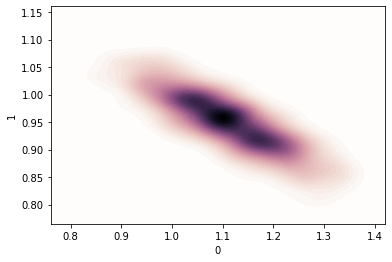

In [131]:
# create the reference posterior distribution
logistic_reference = pd.DataFrame(clean(hmc_results[0], burn_in=0.2))
visualize2d(logistic_reference)

### Naive SGHMC

Naive SGHMC will now be run as well, and is naturally expected to perform poorly.

In [132]:
batch_size = 500
# run naive SGHMC sampler
nsghmc_results = nsghmc(X, Y, M=mass, n_samples=nsamples, negative_log_prob=logistic_nll,
                        initial_position=init_pos, batch_size=batch_size, path_len=path_len, step_size=step_size)

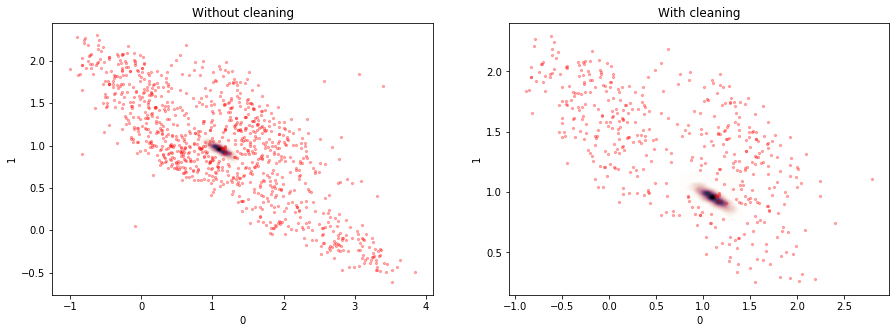

In [133]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
visualize2d(logistic_reference, nsghmc_results[0], title='Without cleaning')
plt.subplot(1, 2, 2)
visualize2d(logistic_reference, clean(nsghmc_results[0], burn_in, thinning), title='With cleaning')

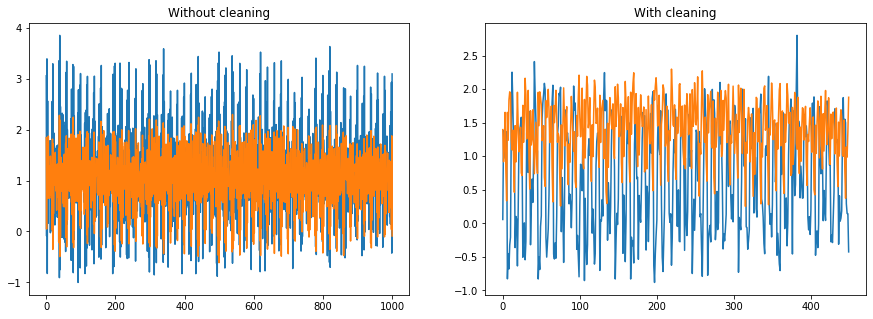

In [134]:
# traceplots
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(nsghmc_results[0])
plt.title('Without cleaning')
plt.subplot(1, 2, 2)
plt.plot(clean(nsghmc_results[0], burn_in, thinning))
plt.title('With cleaning')
plt.show()

Indeed, the same result as in the linear regression example is encountered yet again, with the variance in being too high in all dimensions for sampling the posterior, likely attributable to the stochastic gradients.

### SGHMC

Finally, returning to the SGHMC proposed in the paper, the goal is to have this paper correctly represent the target sampling posterior. Friction, after tuning, was set to $\mathbf{C}=2\mathbf{I}$.

In [141]:
C = 50 * np.eye(2)
V = np.zeros((2, 2))
# run SGHMC sampler
sghmc_results = sghmc(X, Y, M=mass, C=C, V=V, n_samples=nsamples, negative_log_prob=logistic_nll,
                      initial_position=init_pos, batch_size=batch_size, path_len=path_len, step_size=step_size)

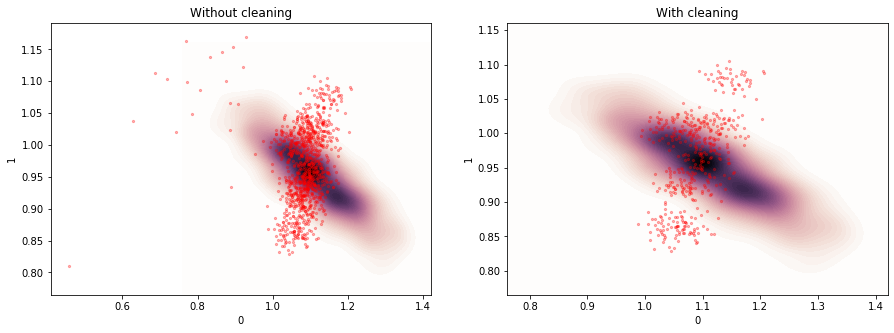

In [142]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
visualize2d(logistic_reference, sghmc_results[0], title='Without cleaning')
plt.subplot(1, 2, 2)
visualize2d(logistic_reference, clean(sghmc_results[0], burn_in, thinning), title='With cleaning')

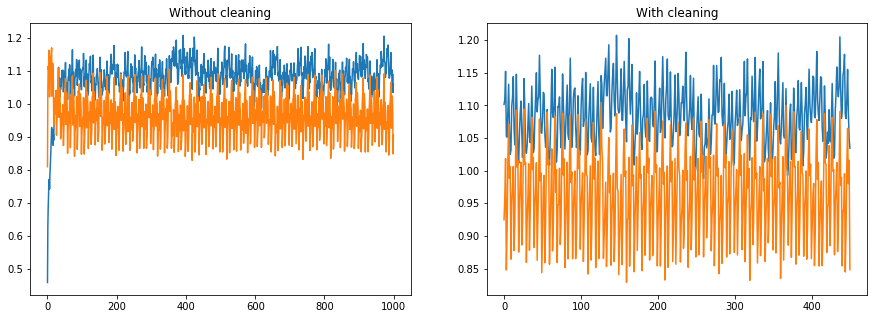

In [143]:
# traceplots
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(sghmc_results[0])
plt.title('Without cleaning')
plt.subplot(1, 2, 2)
plt.plot(clean(sghmc_results[0], burn_in, thinning))
plt.title('With cleaning')
plt.show()

Unfortunately, SGHMC actually does not work very well for Bayesian logistic regression. It makes a good attempt at discovering the approximate location and size of the true distribution, but fails to fully represent it, despite efforts at tuning. This is discussed in greater detail as a good illustration of some of the difficulties with the SGHMC method.

## Artificial Stochastic Gradients

Similar to the pedagogical implementation done by Chen et al. in the reference paper, we explore and compare an implementation of HMC that attempts to approximate the distribution of some specified function, U, rather than taking pre-sampled input data $X,Y$. To do this, our HMC implementation uses the gradient of U in place of the negative log probability we used for the preceding sections. Furthermore, in order to implement naive stochastic gradient HMC and stochastic gradient HMC functions for this simulated scenario, we introduce stochasticity through an artificial noise term in the gradient of U:

$$\nabla \tilde{U} = \nabla U + \mathcal{N}(0,4) $$

We then use $\nabla \tilde{U}$ instead of $\nabla U$ in both the naive and non-naive stochastic gradient HMC; note that for the naive stochastic gradient HMC, we simply use the `HMC` function with the noisy gradient $\nabla \tilde{U}$. Using this "artificial stochastic gradient" is an alternative to pre-constructing noisy data as we do above for the Bayesian linear and logistic regression examples. 

Then, we compare our stochastic gradient implementation, which necessarily does not have an MH correction step, with the HMC and naive stochastic gradient HMC implementations with and without MH correction steps.

In particular, following the lead of the reference paper, we use the function

$$U(\theta) = -2\theta^2 + \theta^4$$

which has the gradient

$$\nabla U = -4\theta + 4\theta^3 $$

We use this gradient in our standard HMC sampler. Meanwhile, in the stochastic gradient samplers, we use the stochastic gradient

$$\nabla \tilde{U} = -4\theta + 4\theta^3 + \mathcal{N}(0,4) $$

We implement these functions in the block of code below and run the five samplers, comparing their approximations against the true distribution of $U$. We use $\eta = 0.1$ for HMC and naive stochastic gradient HMC as specified in the paper and $\eta = 0.001$ for stochastic gradient HMC, which we find works best.

The figure generated below shows the empirical distributions generated by the different sampling algorithms. We embed the figure here, as the code takes more than 10 minutes to run.

<img src="img/artificial_sg_1.png" style="height:350px;">

We discuss the results below.

In [165]:
from hmc import hmc2    # standard HMC sampler for a specified function U
from hmc import sghmc2  # stochastic gradient HMC with friction for artificial stochastic gradients

In [ ]:
# Parameters for third empirical example with artificial stochastic gradients
nsamples = 100000
init_pos = np.array([0.])
mass = np.eye(1)
step_size = 0.1
step_size_SGHMC = 0.001
path_len = 50*step_size
path_len_SGHMC = 50*step_size_SGHMC
burn_in = 0.1
thinning = 10
friction = 3*np.eye(1) 
V = 4*np.eye(1)

# Set up U
def U(x):
    return -2*x**2 + x**4

# Gradient of U without stochasticity
def gradUperfect(x):
    return -4*x + 4*x**3

# Gradient of U with stochasticity
def gradU(x):
    return -4*x + 4*x**3 + 2*np.random.normal()

# Plot line representing histogram
def plot_hist(results, label):
    results = clean(results, burn_in=burn_in, thinning=thinning)
    (n_results, x_results) = np.histogram(results[:,0], bins=30, density=True)
    plt.plot(x_results[:-1], n_results, label=label)

# Plot true distribution
def plot_true():
    x_range = np.arange(-2,2,0.01)
    y_true = np.exp(-U(x_range))
    y_true = y_true / np.sum(y_true) / 0.01
    plt.plot(x_range, y_true, label='True Distribution')

# Set seed for reproducibility
np.random.seed(100)

# HMC with MH
hmc_results = hmc2(M=mass, n_samples=nsamples, U=U, gradU=gradUperfect, initial_position=init_pos, 
                   path_len=path_len, step_size=step_size, diagnostics=True, mh=True)

# HMC without MH
hmc_results_nmh = hmc2(M=mass, n_samples=nsamples, U=U, gradU=gradUperfect, initial_position=init_pos, 
                   path_len=path_len, step_size=step_size, diagnostics=True, mh=False)

# NSGHMC with MH
nsghmc_results = hmc2(M=mass, n_samples=nsamples, U=U, gradU=gradU, initial_position=init_pos, 
                   path_len=path_len, step_size=step_size, diagnostics=True, mh=True)

# NSGHMC without MH
nsghmc_results_nmh = hmc2(M=mass, n_samples=nsamples, U=U, gradU=gradU, initial_position=init_pos, 
                   path_len=path_len, step_size=step_size, diagnostics=True, mh=False)

# SGHMC
sghmc_results = sghmc2(M=mass, C=friction, V=V, n_samples=nsamples, U=U, gradU=gradU, initial_position=init_pos, 
                   path_len=path_len_SGHMC, step_size=step_size_SGHMC, diagnostics=True)

# Set seed for reproducibility
np.random.seed(100)

# Plot true distribution
plt.figure(figsize=(8,6))
plot_true()

# Plot all results
plot_hist(hmc_results[0], label='Standard HMC (with MH)')
plot_hist(hmc_results_nmh[0], label='Standard HMC (no MH)')
plot_hist(nsghmc_results[0], label='Naive Stochastic Gradient HMC (with MH)')
plot_hist(nsghmc_results_nmh[0], label='Naive Stochastic Gradient HMC (no MH)')
plot_hist(sghmc_results[0], label='Stochastic Gradient HMC')
plt.xlabel('$\\theta$')
plt.legend()
plt.show()

Based on the above plot, we can see that the HMC and SGHMC samplers approximate the true distribution quite well, even without the MH correction step. By comparison, the naive SGHMC sampler requires an MH correction step to approximate the true distribution with accuracy; we can see by visual inspection of the plot above that naive SGHMC without an MH correction step deviates considerably from the true distribution. This can be corrected with an MH step, but such a step is computationally costly at scale and SGHMC approximates the distribution well without the inclusion of such a step.

Unfortunately, we find that SGHMC is quite sensitive to miscalibrated friction, and produces questionable results when the friction $C$ is either too small or large. Although in this particular scenario we can workaround this constraint because we know the true stochastic noise introduced in our gradient $U$, in most real-life examples it is unrealistic to know the "true" noise present in most examples. This reinforces our finding that tuning friction to an appropriate value, especially in more complex datasets or functions such as neural networks, is one of the most challenging aspects of SGHMC.

Below, we demonstrate SGHMC's breakdown when we set friction to a value that is too high ($C=15$) to reinforce this. Moreover, when we set friction to a value that is too low ($C=1$), our sampler breaks down and solely returns `NaN` values; we are unable to plot any approximate distribution. We embed the image depicting the distribution approximated by high friction here due to the high run-time of sampling.

<img src="img/artificial_sg_5.png" style="height:350px;">

In [ ]:
# Parameters
nsamples = 100000
step_size_SGHMC = 0.001
path_len_SGHMC = 50*step_size_SGHMC

# SGHMC high friction
sghmc_results_high = sghmc2(M=mass, C=20*np.eye(1) , V=V, n_samples=nsamples, U=U, gradU=gradU, initial_position=init_pos, 
                   path_len=path_len_SGHMC, step_size=step_size_SGHMC, diagnostics=True)

# Plot results
plt.figure(figsize=(8,6))
plot_true()
plot_hist(sghmc_results_high[0], label='SGHMC with Friction of 20')
plt.legend()
plt.show()

Below, we explore the sensitivity of HMC (with MH), NSGHMC (with MH), and SGHMC in this simulated set-up to step size $\eta$. We embed the pictures from our results here, as this takes approximately more than 20 minutes to run for $100,000$ samples.

<img src="img/artificial_sg_2.png" style="height:350px;">
<img src="img/artificial_sg_3.png" style="height:350px;">
<img src="img/artificial_sg_4.png" style="height:350px;">

Based on the figures produced, we can see that SGHMC is the most sensitive to step size of the three methods, and HMC  is the least sensitive. Furthermore, we observe that SGHMC appears to have an optimal step size that is neither too small nor too large; in this case, it is  somewhere around 0.001, which is what  we use for our simulations above. A similar argument might be made for HMC and NSGHMC, which have worse distributions for step sizes that are too small.

In [ ]:
# Set seed for reproducibility
np.random.seed(100)
nsamples = 100000

# List to store sampler results for different step sizes
hmc_results2 = []
nsghmc_results2 = []
sghmc_results2 = []

# Iterate over different step sizes
for step_size in [0.1, 0.01, 0.001]:
    hmc_results2.append(hmc2(M=mass, n_samples=nsamples, U=U, gradU=gradUperfect, initial_position=init_pos,
                             path_len=50*step_size, step_size=step_size, diagnostics=True, mh=True))
    nsghmc_results2.append(hmc2(M=mass, n_samples=nsamples, U=U, gradU=gradU, initial_position=init_pos, 
                                path_len=50*step_size, step_size=step_size, diagnostics=True, mh=True))
    sghmc_results2.append(sghmc2(M=mass, C=friction, V=V, n_samples=nsamples, U=U, gradU=gradU, 
                                initial_position=init_pos, path_len=50*step_size, 
                                step_size=step_size, diagnostics=True))

# Plot HMC results
plt.figure(figsize=(8,6))
plot_true()
for i, step_size in zip(range(3), [0.1, 0.01, 0.001]):
    plot_hist(hmc_results2[i][0], label='HMC with $\\eta = {}$'.format(step_size))
    plt.xlabel('$\\theta$')
plt.legend()
plt.show()

# Plot NSGHMC results
plt.figure(figsize=(8,6))
plot_true()
for i, step_size in zip(range(3), [0.1, 0.01, 0.001]):
    plot_hist(nsghmc_results2[i][0], label='NSGHMC with $\\eta = {}$'.format(step_size))
    plt.xlabel('$\\theta$')
plt.legend()
plt.show()

# Plot SGHMC results
plt.figure(figsize=(8,6))
plot_true()
for i, step_size in zip(range(3), [0.1, 0.01, 0.001]):
    plot_hist(sghmc_results2[i][0], label='SGHMC with $\\eta = {}$'.format(step_size))
    plt.xlabel('$\\theta$')
plt.legend()
plt.show()

We consider one additional simulated scenario that Chen et al. simulates (in their Figure 2) to empirically visualize Hamiltonian dynamics with and without friction, corresponding to naive SGHMC and SGHMC respectively. In this example, we have the function

$$U(\theta) = \frac{1}{2}\theta^2$$

with gradient $\nabla U = \theta$. For our stochastic gradient simulations, we use the noisy gradient $\nabla \tilde{U} = \theta + \mathcal{N}(0,4)$.

The plot below visualizes the distribution of points ($\theta, p$) over $10,000$ steps, where $p$ is the momentum sampled by HMC and SGHMC and is denoted as such in our code.

The result we see is exactly as expected: the inclusion of friction restricts the path primarily to areas of higher density in the function $U$. This is consistent with our understanding of friction; it allows for well-behaved dynamics and allows convergence to the correct stationary distributions.

In [ ]:
# Set up U
def U2(x):
    return 0.5*x**2

# Gradient of U without stochasticity
def gradU2perfect(x):
    return x

# Gradient of U with stochasticity
def gradU2(x):
    return x + 2*np.random.normal()

# Parameters
nsamples = 10000
init_pos = np.array([0.])
mass = np.eye(1)
step_size = 0.1
step_size_SGHMC = 0.01
path_len = 50*step_size
path_len_SGHMC = 50*step_size_SGHMC
friction = 3*np.eye(1) 
V = 4*np.eye(1)

# Run samplers
hmc_results3 = hmc2(M=mass, n_samples=nsamples, U=U2, gradU=gradU2, initial_position=init_pos, 
                   path_len=path_len, step_size=step_size, diagnostics=True, mh=False)

sghmc_results3 = sghmc2(M=mass, C=friction, V=V, n_samples=nsamples, U=U2, gradU=gradU2, 
                        initial_position=init_pos, path_len=path_len_SGHMC, step_size=step_size_SGHMC, diagnostics=True)

# Visualize distributions
plt.figure(figsize=(8,8))
plt.scatter(clean(hmc_results3[0], burn_in=burn_in, thinning=thinning), 
            clean(hmc_results3[1], burn_in=burn_in, thinning=thinning), 
            alpha=0.15, label='Noisy Hamiltonian dynamics')
plt.scatter(clean(sghmc_results3[0], burn_in=burn_in, thinning=thinning), 
            clean(sghmc_results3[1], burn_in=burn_in, thinning=thinning), 
            alpha=0.15, label='Noisy Hamiltonian dynamics with friction')
plt.xlabel('$\\theta$')
plt.ylabel('$p$ (Momentum)')
plt.legend()
plt.show()

![](img/t1.png)

## Computational Complexity

One of the primary objectives behind derivating a technique like SGHMC as presented here is the improvement in computational complexity. The stochastic gradient trick is widely known for improving the performance of other techniques, most notably gradient descent. The motivation is to reduce the resources expended on evaluating the gradient when it is computed on the whole data set by instead choosing just a portion. This specific important aspect of SGHMC will be investigated here.

In order to evaluate these, an extensive suite of diagnostics were built into the HMC, naive SGHMC, and SGHMC implementations included in `hmc.py` to provide an execution profile of each algorithm using Python's `time` module. The diagnostics are enabled by setting the flag `diagnostics=True` in any of the function calls, and the results will be returned as a dictionary. Using the exact same setup as in the [Bayesian linear regression](#Bayesian-Linear-Regression) pedagogical example, each method will be compared for $n=1000$ samples. Note that these are run on a standard personal laptop with a 2.9 GHz Intel i5 processor and 8 GB of memory.

In [147]:
# configuration for true data generating process (DGP)
sigma = 1                  # sigma (observation noise)
n_data_points = 10000      # number of data points in data set
m, b = 1,1                 # true parameters of DGP
# generate the data
X = np.random.uniform(size=n_data_points)
Y = np.random.normal(X * m + b, sigma)
# sampler parametrization
nsamples = 1000
init_pos = np.array([0., 0.])
mass = np.eye(2)
step_size = 1e-3          
path_len = 50 * step_size

burn_in = 0.1
thinning = 2

batch_size = 500

C = 300 * np.eye(2)
V = np.zeros((2, 2))

In [12]:
# run HMC sampler
hmc_results = hmc(M=mass, n_samples=nsamples, negative_log_prob=linear_nll_full, initial_position=init_pos,
                  path_len=path_len, step_size=step_size, diagnostics=True)

In [57]:
# run the naive SGHMC sampler
nsghmc_results = nsghmc(X, Y, M=mass, n_samples=nsamples, negative_log_prob=linear_nll,
                        initial_position=init_pos, batch_size=batch_size, path_len=path_len, step_size=step_size,
                        diagnostics=True)

In [63]:
# run the naive SGHMC sampler without MH step
nsghmc_nomh_results = nsghmc(X, Y, M=mass, n_samples=nsamples, negative_log_prob=linear_nll,
                             initial_position=init_pos, batch_size=batch_size, path_len=path_len,
                             step_size=step_size, mh=False, diagnostics=True)

In [53]:
# run SGHMC sampler
sghmc_results = sghmc(X, Y, M=mass, C=C, V=V, n_samples=nsamples, negative_log_prob=linear_nll,
                      initial_position=init_pos, batch_size=batch_size, path_len=path_len, step_size=step_size,
                      diagnostics=True)

In [68]:
print('Total Running Time for Various Samplers (in seconds)')
print('HMC:\t\t\t', hmc_results[1]['total'])
print('Naive SGHMC:\t\t', nsghmc_results[1]['total'])
print('Naive SGHMC (no MH):\t', nsghmc_nomh_results[1]['total'])
print('SGHMC:\t\t\t', sghmc_results[1]['total'])

Total Running Time for Various Samplers (in seconds)
HMC:			 70.20531105995178
Naive SGHMC:		 48.04396295547485
Naive SGHMC (no MH):	 39.64529204368591
SGHMC:			 40.730266094207764


The running times are quite representative across runs and quite reasonable. We can see that HMC runs substantially slower, and this may not even fully reflect the benefit of stochastic gradient, as the asymptotic properties for even larger data sets will be even greater. Notably, SGHMC actually performs better than naive SGHMC. Note that the naive version without the MH step runs faster, but the MH step is needed for it to maintain correct stationary properties, and the step is in fact quite costly.


The effects can therefore be better visualized across data sets of different orders of magnitudes, as below.

In [159]:
# range of data set sizes
pow_range = range(5)

hmc_times = []
nsghmc_times = []
nsghmc_nomh_times = []
sghmc_times = []

nsamples = 100
batch_size = 10

for p in pow_range:
    # generate the data
    n_data_points = 10 ** (p + 2)
    print('Running for data sets of size', n_data_points)
    X = np.random.uniform(size=n_data_points)
    Y = np.random.normal(X * m + b, sigma)
    
    # run HMC sampler
    hmc_times.append(hmc(M=mass, n_samples=nsamples, negative_log_prob=linear_nll_full, initial_position=init_pos,
                        path_len=path_len, step_size=step_size, diagnostics=True)[1]['total'])
    # run the naive SGHMC sampler
    nsghmc_times.append(nsghmc(X, Y, M=mass, n_samples=nsamples, negative_log_prob=linear_nll,
                            initial_position=init_pos, batch_size=batch_size, path_len=path_len, step_size=step_size,
                            diagnostics=True)[1]['total'])
    # run the naive SGHMC sampler without MH step
    nsghmc_nomh_times.append(nsghmc(X, Y, M=mass, n_samples=nsamples, negative_log_prob=linear_nll,
                                 initial_position=init_pos, batch_size=batch_size, path_len=path_len,
                                 step_size=step_size, mh=False, diagnostics=True)[1]['total'])
    # run SGHMC sampler
    sghmc_times.append(sghmc(X, Y, M=mass, C=C, V=V, n_samples=nsamples, negative_log_prob=linear_nll,
                          initial_position=init_pos, batch_size=batch_size, path_len=path_len, step_size=step_size,
                          diagnostics=True)[1]['total'])

Running for data sets of size 100
Running for data sets of size 1000
Running for data sets of size 10000
Running for data sets of size 100000
Running for data sets of size 1000000


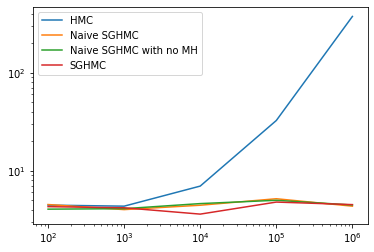

In [163]:
sizes = [10 ** (p + 2) for p in pow_range]
plt.loglog(sizes, hmc_times)
plt.loglog(sizes, nsghmc_times)
plt.loglog(sizes, nsghmc_nomh_times)
plt.loglog(sizes, sghmc_times)
plt.legend(['HMC', 'Naive SGHMC', 'Naive SGHMC with no MH', 'SGHMC'])
plt.show()

The above is a comparison of the running times for all the algorithms for data sets of different sizes. Note that for smaller orders of magnitudes, the difference is negligible. However, for larger sized data sets, HMC increases by orders of magnitude and appears to scale linearly with the data set size based on analysis of computational complexity of the algorithm. However, all methods using the stochastic gradient do not experience such an increase as the algorithm depends exclusively on the batch size, thereby confirming the potentially massive utility of using stochastic gradients for large data sets.

## Freeze Proposal

Increasing friction (C) arbitrarily high will not effect the asymptotic behavior of the function. Returning to the anology of the paper, extremely high friction is equivalent to really rought asphalt that prevents the hockey puck from moving much, but over infinite samples the distribution will still be correct. However, extremely large friction can pose other issues. In partciular, if the initial position of the sampler is extremely far from the main density of the distribution, using a friction that overestimates the stochastic noise drastically increases the burn-in. See the example below, where using a friction level of $1000$ and initial position of $(10,10)$ on a distribution centered at $(1,1)$ means that even after $5000$ samples at a batch size of $300$, it does not get to the center of the distribution. Note that images are embedded due to running time considerations, but code is provided and runnable.

In [ ]:
np.random.seed(124)
from thaw import thaw

In [ ]:
# Test sghmc
sstoc_results = sghmc(X, Y, np.eye(2), 1000, 0 * np.eye(2), 5000, neg_log_prob, np.array([10.,10.]), batch_size=300, path_len=path_len, step_size=step_size)[0]

cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
sns.kdeplot(df.x, df.y, cmap=cmap, n_levels=60, shade=True)
plt.scatter(sstoc_results[:,1], sstoc_results[:,0], alpha=0.5)

![](img/1.png)

While this looks okay at a birds eye view, in reality is has not yet conveged. Zooming in below, we see that it is still burn-in to the center of the distribution. 

In [ ]:
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
sns.kdeplot(df.x, df.y, cmap=cmap, n_levels=60, shade=True)
test = sstoc_results
plt.scatter(test[:,1], test[:,0], alpha=0.5)
plt.xlim(0.8,  1.2)
plt.ylim(0.8,1.2)

![](img/2.png)

On the other hand, we can drastically reduce the burn-in by using a low value for friction. Here are the exact same settings, but with a friction value of $1$ and only $300$ samples (fewer than a tenth from before). The issue below is that after it reaches the high-density area of the distribution, it's sampling distribution is far too wide (due to a low level of friction). This is consistent with our results from our parameter gridsearch.

In [ ]:
# Test sghmc
# Note: graphing code from (https://seaborn.pydata.org/tutorial/distributions.html)
new_X = np.vstack((np.ones(X.shape[0]), X))
mean = np.linalg.inv(np.dot(new_X, new_X.T) + sigma**2 * np.linalg.inv(coef_cov)) @ new_X @ Y
cov = np.linalg.inv(np.dot(new_X, new_X.T) * sigma**(-2) + np.linalg.inv(coef_cov))
data = np.random.multivariate_normal(mean, cov, 200)
df = pd.DataFrame(data, columns=["x", "y"])
fstoc_results = sghmc(X, Y, np.eye(2), 1, 0 * np.eye(2), 300, neg_log_prob, np.array([10.,10.]), batch_size=300, path_len=path_len, step_size=step_size)[0]

cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
sns.kdeplot(df.x, df.y, cmap=cmap, n_levels=60, shade=True)
plt.scatter(fstoc_results[:,1], fstoc_results[:,0], alpha=0.5)

![](img/3.png)

So we see that if we have an initialization point that is extremely far away, it can take an immense amount of burn-in to find it successfully. This is an extremely relevant problem. We often use samplers on extremely complex distribution where it may be intractable to find the maximum (or we may not have the mathematical ability to find it). Thus, we may have to guess where to initialize the sampler, and burn-in is extremely relevant. This problem inspired our modification. 

In Lecture 13, we discussed using temperature with simulated annealing. Our proposed modification is to have the option to start at a low friction, and gradually increase this friction. We term this "thawing," since it corresponds to the friction levels as ice melts (again consistent with the analogy of the paper). We start with ice (low friction), and as the ice melts, the road becomes exposed (higher friction). We try a couple of different implementations. This will take advantage of the fast-convergence of low friction values but preserve the superior sampling ability of the higher values of friction.

The next logical question is how we can determine when to increase friction. To do this, we look at the traceplots of the $1$-friction sampler. We want to know when the $1$-friction sampler has reached the high-density area of the distribution so that we can raise the friction. Note that what we are concerned with here is not necessarily asymptotic properties but convergence towards high density areas. As such, we may be willing to have friction levels lower than the stochastic noise because this asymptotic guarantee is less valuable to us than the benefit of speedier convergence. Below is the traceplot of the $1$-friction sampler.

In [ ]:
plt.plot(fstoc_results[:,1])
plt.plot(fstoc_results[:,0])

![](img/4.png)

We see a good measure of if the sampler is still in burn-in or has converged is the slope in its past samples (for a single variable). We don't want to use slope of the samples over it's lifetime, as the sampling curve is exponential, so we are more concerned with the slope over the past $n$ samples for relatively small $n$. If this slope is relatively flat, this leads us to believe the sampler has converged (note this is the average slope--we don't want our samplers to converge to a constant). It's hard to judge if a slope is "flat" (since there are different levels of variance for different distributions), so instead we use do the following. After the first 10 iterations, we calculate the overall slope of the first 10 samples. Call this the \textbf{initial slope} We use this to verify when the slope is becoming "flat," and the sampler has converged. The exact condition we use is if the \textbf{initial slope} has the opposite sign of the slope in the past 10 variables, this is partial evidence the sampler has converged (since the burn-in usually happens in one direction). Note that we all variables to be flat to increase friction.

Thus, we initially tried setting a binary cutoff for jumping from a friction of $1$ to the user-specified level of friction (in this case $500$). This was unsuccessful because the slope of the past samples looked good much before the sampler had reached the high-density area, and since most of the time from a high-friction sampler is lost in the fine-tuning, this does not provide a substantial speedup. To make this concrete, below I have the traceplot for the original $1000$ friction run. We see it gets from $(10,10)$ to $(0,2)$ in about $500$ samples, but then takes another $5000$ samples to get to almost converged, so most of the time is lost in refining when the sampler is very close to the high-density area. Thus, early thawing is disasterous for efficient burn-in

In [ ]:
plt.plot(sstoc_results[:,1])
plt.plot(sstoc_results[:,0])

![](img/5.png)

Thus, we attempted to create a rule for increasing the friction incrementally. We observed from the traceplots that if the slope of the past $n$ points is relatively flat, this increases our belief that the sampler has converged, but not completely (as we saw with the failure of our first design). Since we are checking at every point to see if it has a small slope in the past $n$ points, we decided to use the frequency of low-slope readings to decide how much to increase friction by. In particular, if the frequencey of "flat" slopes is increasing, we want to increase friction more rapidly. The algorithm works as follows

1. Initialize a set of all the variables our sampler is sampling from (in this case m,b), and call this \textbf{frozen variables}.
2. After every iteration, for each variable, check if the slope of the past n (in this case 10) variables has the opposite sign to the \textbf{initial slope}. If so, remove it from frozen variables.
3. If all variables have been removed from frozen variables, denote the current iteration number $i_c$ and the last iteration number at which friction was increased $i_l$. Increase the friction by $e^{\frac{5}{i_c-i_l + 1}}$ (the $+1$ is to prevent division by zero errors, but the overall idea is that if $i_c-i_l$ is smaller so we recently increased the friction, we increase the friction by a larger amount). Then reset all variables back into frozen variables.

Below, we present the results for our thawing sampler (first naturally for comparison and then with burn-in and thinning so that it is evident it has found the correct distribution). We use a maximum friction of $300$.

In [ ]:
stoc_results, _, auto_corr = thaw(X, Y, np.eye(2), 300, 0 * np.eye(2), 1400, neg_log_prob, np.array([10.,10.]),
                                  batch_size=300, path_len=path_len, step_size=step_size)

In [ ]:
burn_in = 0.5
thinning=5
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
sns.kdeplot(df.x, df.y, cmap=cmap, n_levels=60, shade=True)
stoc_results2 = stoc_results
plt.scatter(stoc_results2[:,1], stoc_results2[:,0], alpha=0.5)
plt.xlim(0.8,  1.2)
plt.ylim(0.8,1.2)

![](img/6.png)

In [ ]:
burn_in = 0.3
thinning=5
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
sns.kdeplot(df.x, df.y, cmap=cmap, n_levels=60, shade=True)
stoc_results2 = stoc_results[int(burn_in * stoc_results.shape[0])::thinning]
plt.scatter(stoc_results2[:,1], stoc_results2[:,0], alpha=0.5)
plt.xlim(0.8,  1.2)
plt.ylim(0.8,1.2)

![](img/7.png)

The main quesiton for validation is if this is better performance than just setting the friction to $300$ overall. Let's run $1400$ iterations for normal SGHMC on $300$ friction overall.

In [ ]:
mstoc_results = sghmc(X, Y, np.eye(2), 300, 0 * np.eye(2), 1400, neg_log_prob, np.array([10.,10.]), batch_size=300, path_len=path_len, step_size=step_size)[0]

cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
sns.kdeplot(df.x, df.y, cmap=cmap, n_levels=60, shade=True)
plt.scatter(mstoc_results[:,1], mstoc_results[:,0], alpha=0.5)
plt.xlim(0.8,  1.2)
plt.ylim(0.8,1.2)

![](img/8.png)

We see the $300$ friction sampler has actually not converged! We can do more by comparing the traceplots. First for thawing

In [ ]:
plt.plot(stoc_results[:,1])
plt.plot(stoc_results[:,0])

![](img/9.png)

Now for the traceplot of SGHMC.

In [ ]:
plt.plot(mstoc_results[:,1])
plt.plot(mstoc_results[:,0])

![](img/10.png)

We see in the traceplots that the main advantage of thawing is at the beginning. The low-friction values cause much faster convergence at the beginning. The model does not have to burn-in at $300$ friction from $(10,10)$, but instead gets much closer to the high-density area before switching to a higher friction value. So while there is definitley more research that needs to be done, our experiments demonstrate that thawing is a promising method for reducing burn-in time, especially for initial positions that are very far from distributions.

## Discussion

The benefits of taking a stochastic gradient are quite clear and are not really disputed. In many other fundamental machine learning algorithms, the stochastic gradient trick has been successfully applied with great advantages, such as in stochastic gradient descent and stochastic gradient Langevin dynamics, so much that they have sometimes been used to a greater degree than their deterministic counterparts. Therefore, the question largely becomes what are the trade-offs of using SGHMC.

### Greater Model Complexity
The largest one is **additional complexity in parametrization**, specifically tuning friction. Stochastic gradient algorithms typically require the extra step of choosing a batch size, as is needed for SGHMC as well, but this is typically straightforward. Unfortunately, SGHMC requires a friction term that upper bounds the empirical variance of the stochastic gradients. Empirically estimating this quantity at all is very difficult for large data sets and is not even recommended by the authors themselves, and so tuning this parameter becomes almost arbitrary. A huge challenge in larger and more sophisticated models like Bayesian neural networks is already the parametrization given that there is such a large parameter space to explore. By adding this additional hyperparameter, if there are no good heuristics or apriori intuition for what the friction term should be, using SGHMC may very well further complicate the training problem while going against the principle of parsimony in model-construction.

### More Precise Parametrizations
In this vein, SGHMC has the issue where it **demands more precise parametrizations**. This is a _novel result_ not discussed in the paper. Through the course of tuning the samplers for these pedagogical examples, it was discovered that SGHMC is particularly sensitive to other parameters, the most notable being step size $\epsilon$. There is some reasonable intuition for this. Friction was derived as a means of countering the large variance that is introduced by stochastic gradients. Naturally, it restricts the movement of the sampler, but cannot be too high or else the sampler fails to effectively explore the parameter space. Every step could potentially be very highly autocorrelated due to the complete lack of freedom. However, with lower friction, the stochasticity remains an issue even if the magnitude of the variance is controlled, as there is freedom but not well-controlled due to the randomness of the gradient. Therefore, a sufficiently small step size is needed to correctly explore the sample space, in addition to a well-chosen friction. Consequently, it is possible that other parameters like path length will require more consideration as well. More generally, this further complicates the model selection process, as some of our results also show, especially since more standard techniques like the original HMC are significantly more flexible and less restrictive when it comes to these combinations of parameters.

### Reduced Effective Sample Size

As noted in several pedagogical examples, the effective sample size is drastically reduced due to the much greater amount of samples spent in the burn-in to travel towards the correct location of the distribution. This is likely attributable to the introduction of friction. While it counters the undesirable randomness of stochastic gradients, it comes at the cost of moving slower. Granted, each iteration is asymptotically faster, which is desirable especially for large data sets and likely outweighs the extra iterations needed. However, the fact that more iterations is needed is a consideration that modelers should be aware of, especially as it may be difficult in real settings to determine where the sampler should travel to (i.e. where the true mean is).

## Conclusion

While SGHMC as an algorithm has payoffs in its improved speed and explorative sampling, which are advantageous when approximating complex, real-world distributions, we find that the algorithm is not without tradeoffs. We use simple, but effective pedagogical examples to test the performance of the algorithm under a host of different scenarios.

We saw a number of limitations arise in our experiments. In experimenting with friction and batch size through gridsearch, we found that overly high levels of friction can cause low-density areas of the distribution to go unsampled. In our experiments with thawing, we found that high values of friction can lead to extremely high burn in times. Furthermore, we saw that there existed a reasonably large bias in the sampling distribution of the sample mean of our posteriors when we performed our Bias Variance Analysis. However, friction also helped to contribute to improving the quality of our posterior’s covariance shape.

In our work on artificial stochastic gradients, in which we recreate some of the figure from our reference paper, we find that the SGHMC algorithm is over-sensitive to changes step size, more so than HMC or NSGHMC, in exchange for quicker run-time. Although SGHMC is quicker than HMC or NSGHMC for a specified step size, it - at least in the examples we discuss in the artificial stochastic gradients - requires step sizes that are smaller by at least an order of magnitude for accurate approximations.

The BNN and Probabilistic Matrix Factorization applications from the paper are convincing in demonstrating applicability of SGHMC, and overall, we think SGHMC is a powerful strategy for reducing computational time for sampling complex posteriors. However, we found through powerful experiments that there are certainly issues that can be addressed by future research to improve this method.

## Acknowledgements

We would like to thank Weiwei Pan for her generous support, advice, and feedback throughout the entire process. We would also like to thank our TF, Sijie Sun, for his involvement in guiding us.

## References

Colin Carroll. (2019, April 11). Hamiltonian Monte Carlo from scratch. Retrieved from https://colindcarroll.com/2019/04/11/hamiltonian-monte-carlo-from-scratch/.

Duane, S., Kennedy, A., Pendleton, B. J., & Roweth, D. (1987). Hybrid Monte Carlo. Physics Letters B, 195(2), 216–222. doi: 10.1016/0370-2693(87)91197-x

Hoffman, M.D., Blei, D. M., Wang, C., and Paisley, J. Stochastic variational inference. Journal of Maching Learning Research, 14(1):1303–1347, May 2013.

Nemirovski, A., Juditsky, A., Lan, G., and Shapiro, A. Robust stochastic approximation approach to stochastic programming. SIAM Journal on Optimization, 19(4): 1574–1609, January 2009.

Robbins, H. and Monro, S. A stochastic approximation method. The Annals of Mathematical Statistics, 22(3): 400–407, 09 1951.

Welling, M. and Teh, Y.W. Bayesian learning via stochastic gradient Langevin dynamics. In Proceedings of the 28th International Conference on Machine Learning (ICML’11), pp. 681–688, June 2011.

End of notebook